In [1]:
import torch
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
import sys
sys.path.append('../src')
from utils import encode_image
from jupyter_bbox_widget import BBoxWidget
import pandas as pd

import cv2
import numpy as np
import supervision as sv
from strategies import *

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = "/root/Master_Thesis/sam/sam_vit_h_4b8939.pth"

In [3]:
main_path = "/root/Master_Thesis/"
dataframes_path = main_path + "data/dataframes/"
sam_path = main_path + "sam/sam_vit_h_4b8939.pth"
expirements_path = main_path+"expirements/"

In [4]:
params = {'n_epoch': 25,
          'train_args':{'batch_size': 4, 'num_workers': 1},
          'test_args':{'batch_size': 256, 'num_workers': 1},
          'optimizer_args':{'lr': 5e-3, 'momentum': 0.9},
          'use_sam': True,
          'use_predictor': True,
          'use_generator': False,
          'init_set_size': 100,
          'query_num': 2, #int(0.1*len(test_df)),
          'rounds': 4,
          "activate_sam_at_round":3, 
          #'test_set_size': len(test_df),
          #'df': df_name
          "img_size": (128, 128)}

params["strategy"] = "MarginSampling"
params["voters"] = f'trained_models/voters/voters_{params["img_size"][0]}_'

In [5]:
sam = SAMOracle(checkpoint_path=sam_path, img_size=params["img_size"])

In [6]:
df_name = "brain_df"
train_df = pd.read_csv(dataframes_path+"brain_df_train.csv")
test_df = pd.read_csv(dataframes_path+"brain_df_test.csv")

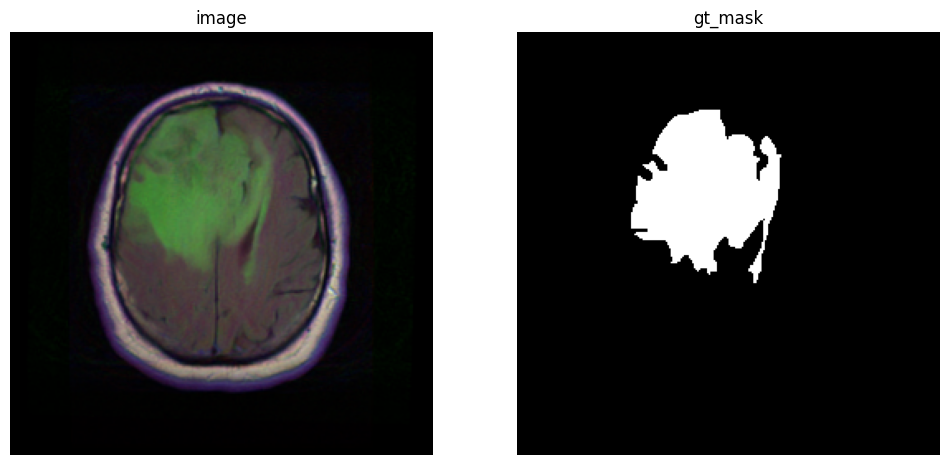

In [7]:
# i = np.random.randint(1, len(df))
# i = 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10
i=10
import supervision as sv

image = cv2.imread(test_df["images"][i])
gt_mask = cv2.imread(test_df["masks"][i])
# gt_mask = np.sum(gt_mask, axis=2)
sv.plot_images_grid(
    images=[image, gt_mask[:, :, 0]],
    grid_size=(1, 2),
    titles=['image', 'gt_mask']
)

In [8]:
test_df_slice = test_df[i:i+1]

In [9]:
def get_data(handler, train_df, test_df):
    return Data(train_df["images"].to_list(), train_df["masks"].to_list(), test_df["images"].to_list(), test_df["masks"].to_list(), handler, img_size=params["img_size"], df=train_df, path= main_path+"/data/processed/", use_sam=params['use_sam'])

In [10]:
from custom_datasets import *

data = get_data(Handler, train_df, test_df_slice)
data.initialize_labels(params["init_set_size"])

In [11]:
model = smp.create_model(
            'Unet', encoder_name='resnet34', in_channels=3, classes = 1
        )

net = Net(model, params, device = torch.device("cuda"))

In [12]:
def predict(net, model_state:str):
    net.net.load_state_dict(torch.load(model_state))
    net.clf = net.net.to(torch.device("cuda"))
    mask = net.predict(data.get_test_data())[0]
    mask = (mask.squeeze().cpu().sigmoid()> 0.5).float()
    
    return mask
    

In [13]:
masks = [predict(net, params["voters"]+f'/model_{i}.pt') for i in range(1, 11)]
t = torch.tensor(np.array(masks))

In [16]:
majority = t.mode(0).values

In [17]:
majority.shape

torch.Size([10, 128])

In [184]:
masks.append(majority)
masks.append(gt_mask[:, :, 0])

titles = [f"mask_{i}" for i in range(1,11)]
titles.append("majority")
titles.append("gt_mask")


In [185]:
def get_boxes(mask):
    if torch.is_tensor(mask):
        mask = mask.numpy()
        mask = np.array(mask, np.uint8)
    # _, thresh = cv2.threshold(mask, 0.5, 1, 0)
    contours, _ = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = []
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)
        box = np.array([x, y, x+w, y+h])
        cnts.append(box)
    return np.array(cnts)   

In [186]:
boxes = [get_boxes(mask) for mask in masks[:10]]

In [187]:
sam_masks=[sam.get_mask(img_path=test_df_slice["images"][i], boxes=box)[0] for box in boxes]

# Majority Voting: Mode

In [188]:
t = torch.tensor(np.array(sam_masks))
sam_majority = t.mode(0).values

In [189]:
sam_masks.append(sam_majority)
sam_masks.append(gt_mask)

sam_titles = [f"sam_mask_{i}" for i in range(1,11)]
sam_titles.append("sam_majority")
sam_titles.append("gt_mask")

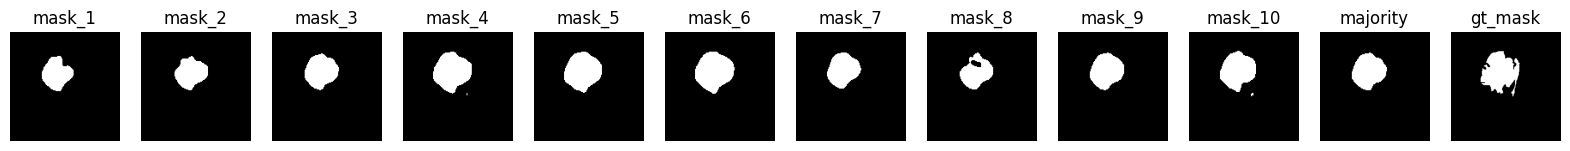

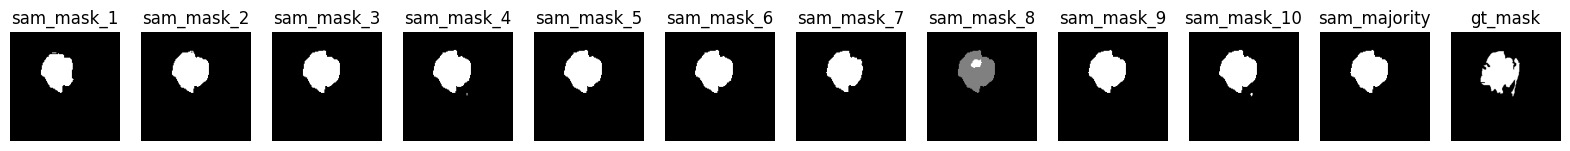

In [190]:
# i=10
sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
    titles=titles,
    size = (20,20)
)
sv.plot_images_grid(
    images=sam_masks,
    grid_size=(1, len(sam_masks)),
    titles=sam_titles,
    size = (20,20)
)

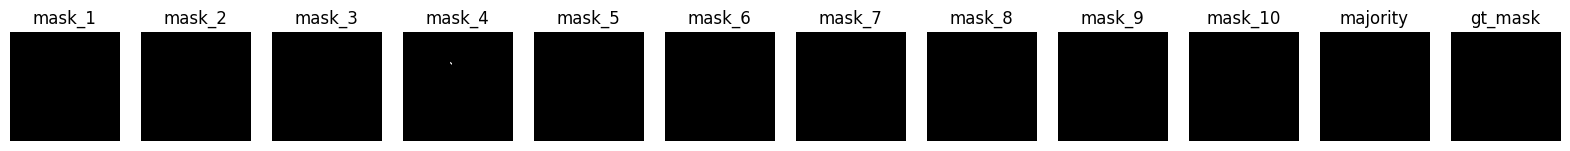

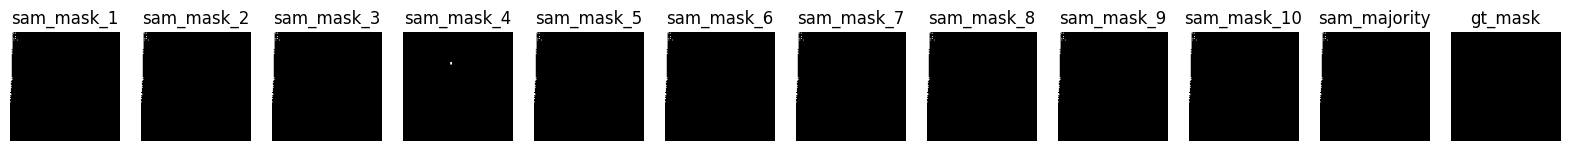

In [175]:
# i=9
sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
    titles=titles,
    size = (20,20)
)
sv.plot_images_grid(
    images=sam_masks,
    grid_size=(1, len(sam_masks)),
    titles=sam_titles,
    size = (20,20)
)

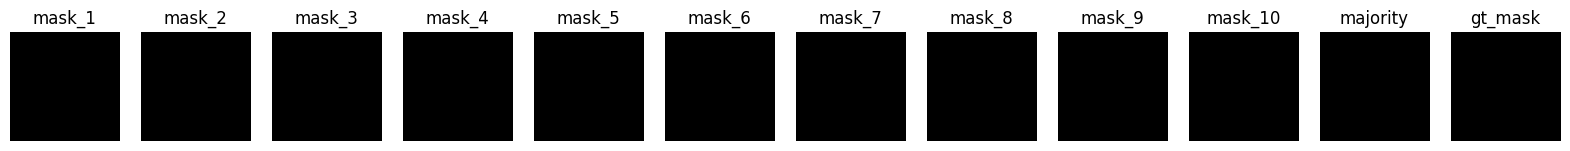

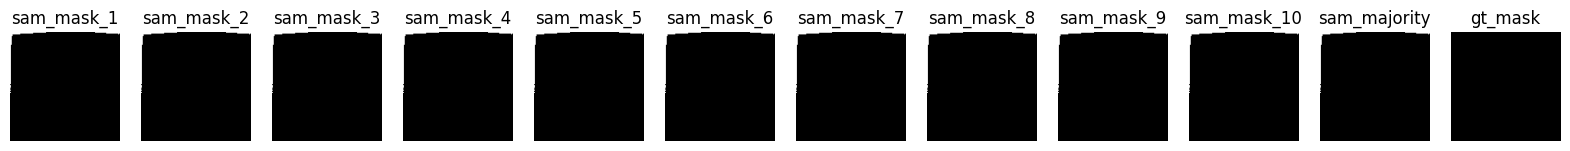

In [160]:
# i=8
sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
    titles=titles,
    size = (20,20)
)
sv.plot_images_grid(
    images=sam_masks,
    grid_size=(1, len(sam_masks)),
    titles=sam_titles,
    size = (20,20)
)

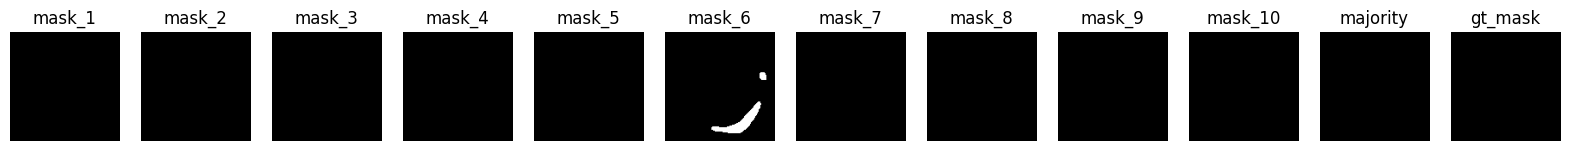

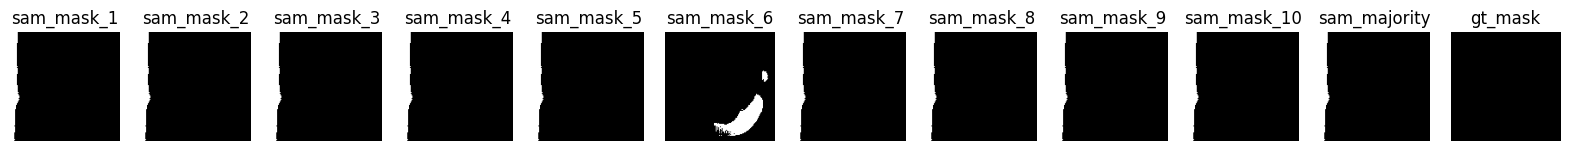

In [145]:
# i=7
sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
    titles=titles,
    size = (20,20)
)
sv.plot_images_grid(
    images=sam_masks,
    grid_size=(1, len(sam_masks)),
    titles=sam_titles,
    size = (20,20)
)

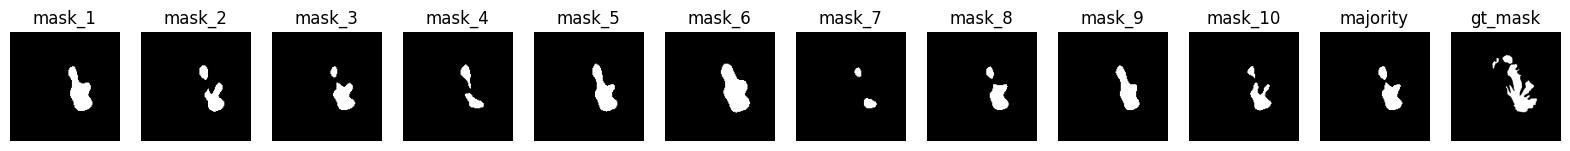

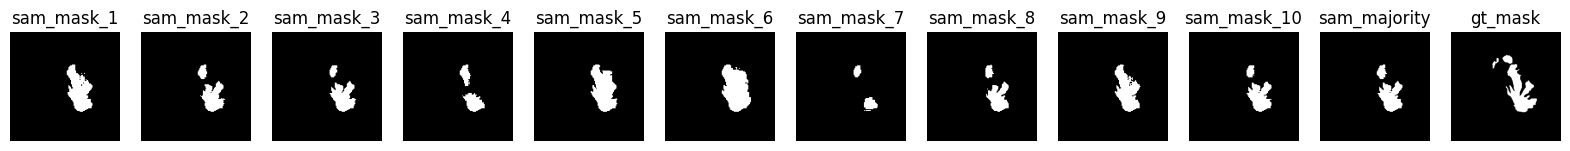

In [36]:
# i=6
sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
    titles=titles,
    size = (20,20)
)
sv.plot_images_grid(
    images=sam_masks,
    grid_size=(1, len(sam_masks)),
    titles=sam_titles,
    size = (20,20)
)

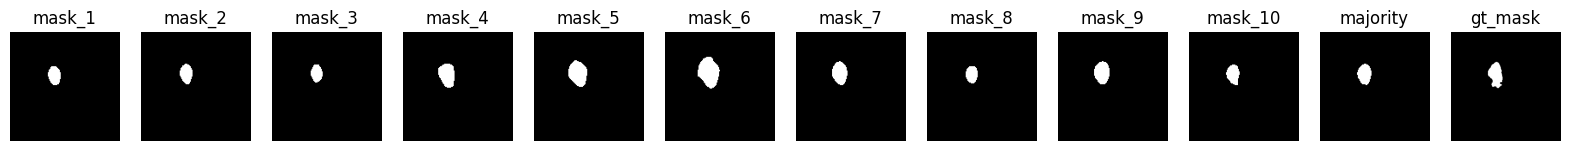

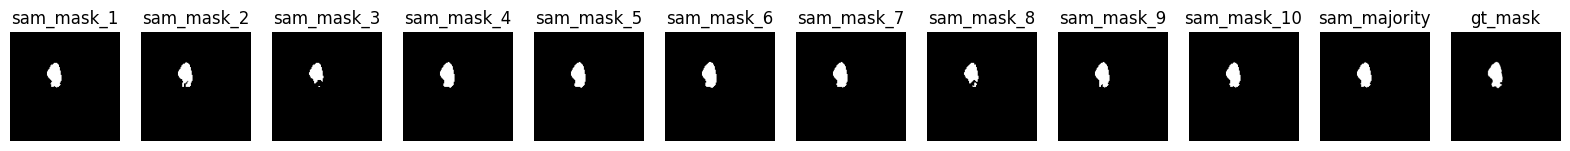

In [130]:
# i=5
sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
    titles=titles,
    size = (20,20)
)
sv.plot_images_grid(
    images=sam_masks,
    grid_size=(1, len(sam_masks)),
    titles=sam_titles,
    size = (20,20)
)

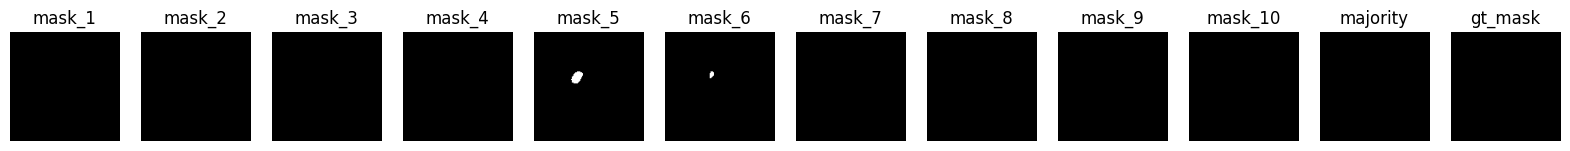

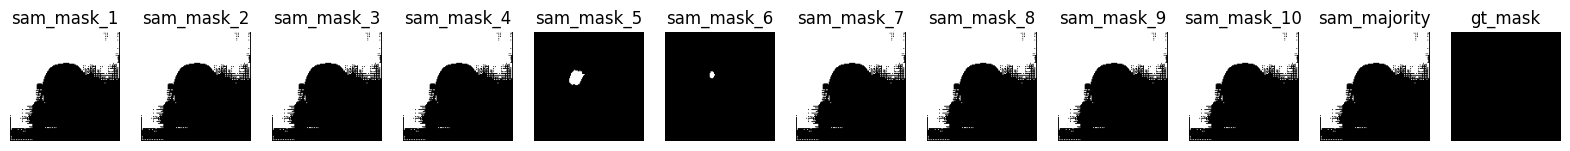

In [115]:
# i=4
sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
    titles=titles,
    size = (20,20)
)
sv.plot_images_grid(
    images=sam_masks,
    grid_size=(1, len(sam_masks)),
    titles=sam_titles,
    size = (20,20)
)

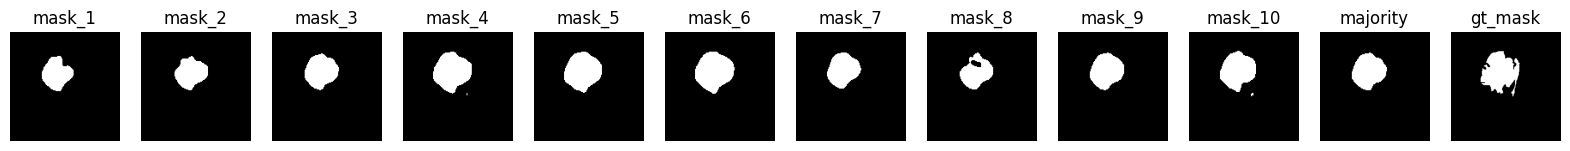

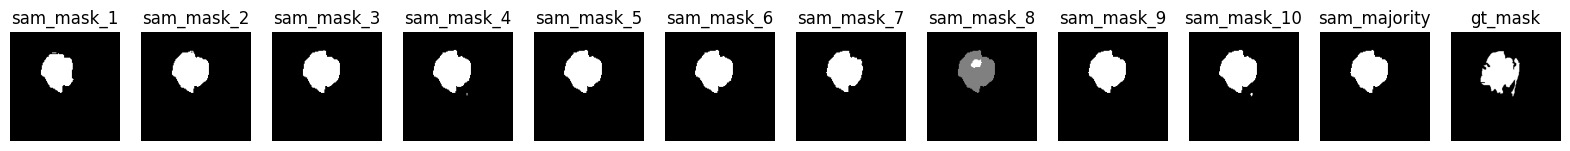

In [ ]:
# i=3
sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
    titles=titles,
    size = (20,20)
)
sv.plot_images_grid(
    images=sam_masks,
    grid_size=(1, len(sam_masks)),
    titles=sam_titles,
    size = (20,20)
)

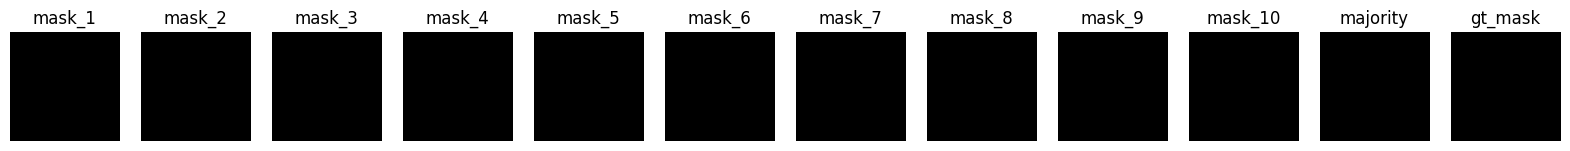

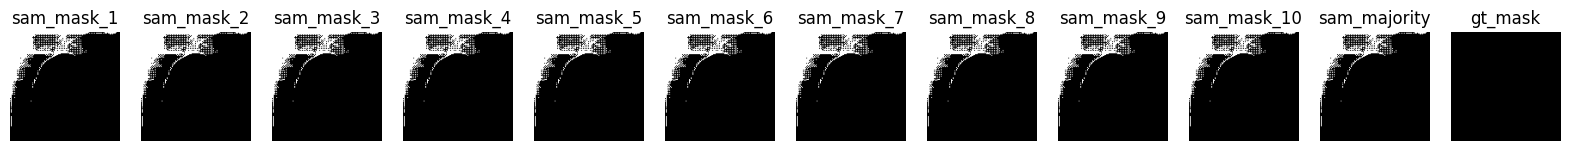

In [99]:
# i=2
sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
    titles=titles,
    size = (20,20)
)
sv.plot_images_grid(
    images=sam_masks,
    grid_size=(1, len(sam_masks)),
    titles=sam_titles,
    size = (20,20)
)

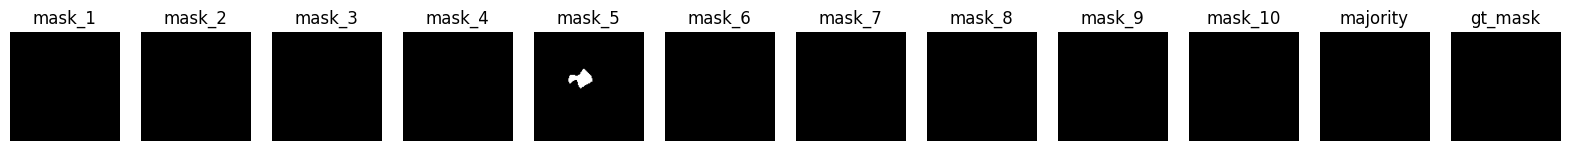

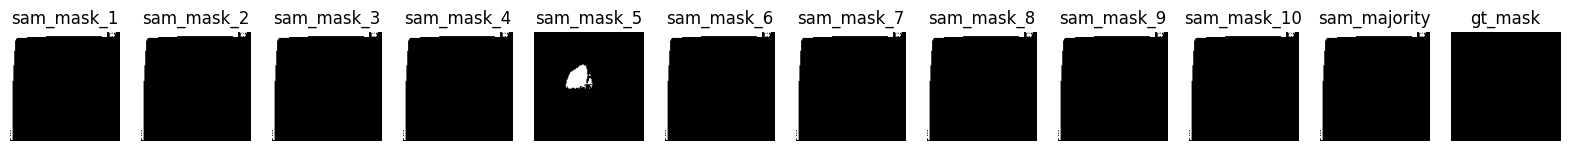

In [84]:
# i=1
sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
    titles=titles,
    size = (20,20)
)
sv.plot_images_grid(
    images=sam_masks,
    grid_size=(1, len(sam_masks)),
    titles=sam_titles,
    size = (20,20)
)

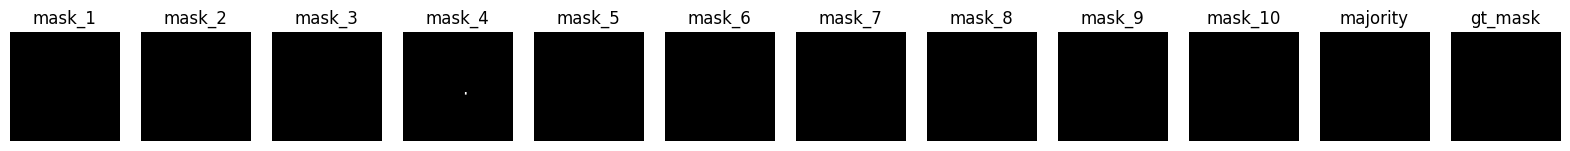

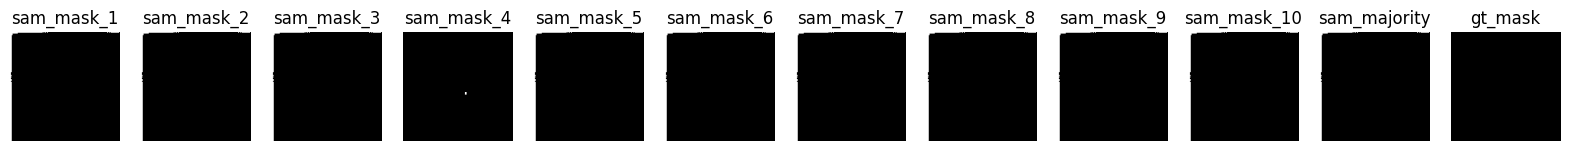

In [69]:
# i = 0
sv.plot_images_grid(
    images=masks,
    grid_size=(1, len(masks)),
    titles=titles,
    size = (20,20)
)
sv.plot_images_grid(
    images=sam_masks,
    grid_size=(1, len(sam_masks)),
    titles=sam_titles,
    size = (20,20)
)

In [31]:
box = get_boxes(masks[1])
G_masks = sam.get_multimask(img_path=test_df_slice["images"][i], boxes=box)

In [33]:
G_masks = [(mask.sum(axis=0).squeeze().cpu() > 2 ).float().numpy() for mask in G_masks]


In [37]:
G_masks.append(gt_mask[:,:,0])

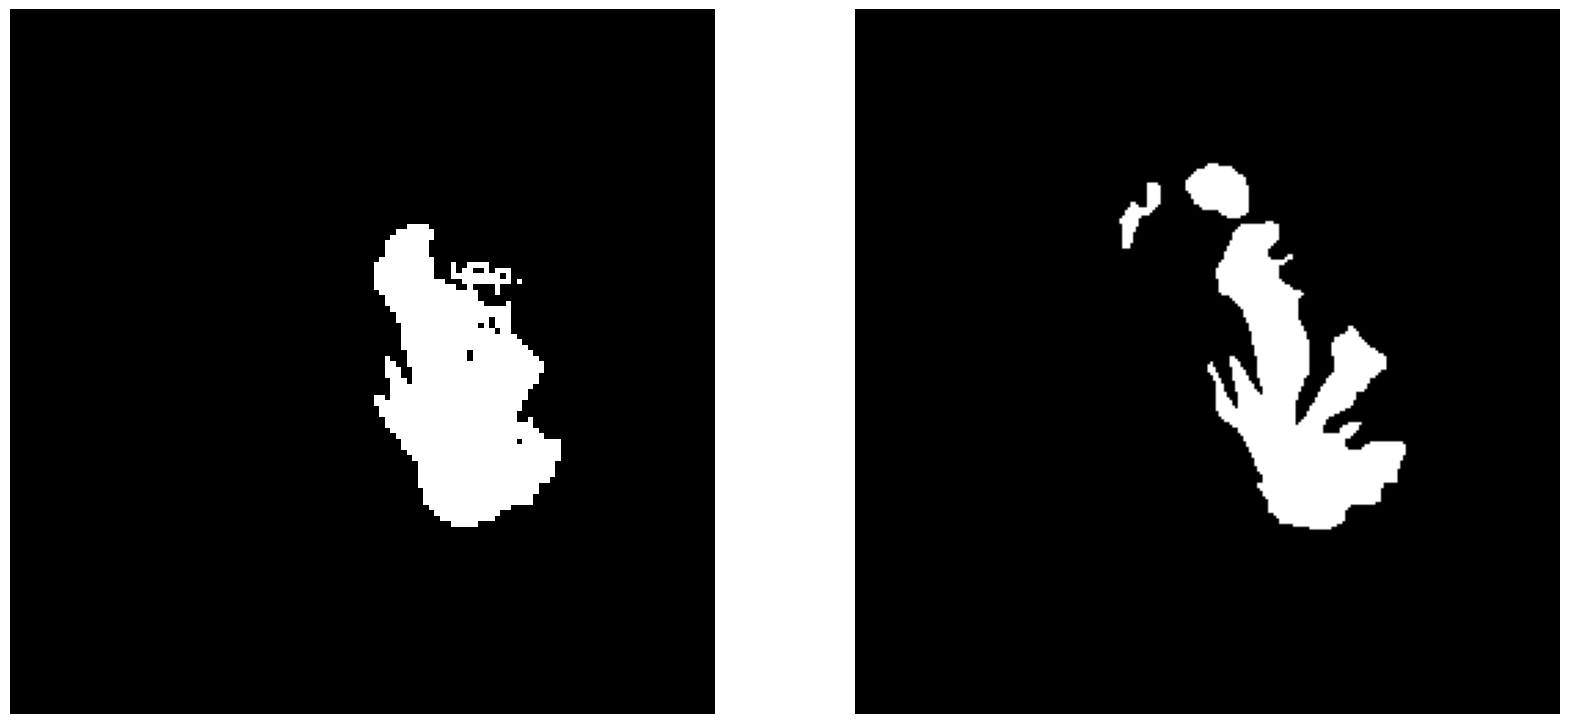

In [41]:
sv.plot_images_grid(
    images=G_masks,
    grid_size=(1, len(G_masks)),

    size = (20,20)
)

In [28]:
from scipy.stats import mode

combined = np.array([sam_mask_1, sam_mask_2, sam_mask_3, sam_mask_4, sam_mask_5])
majority_vote = mode(combined)[0]

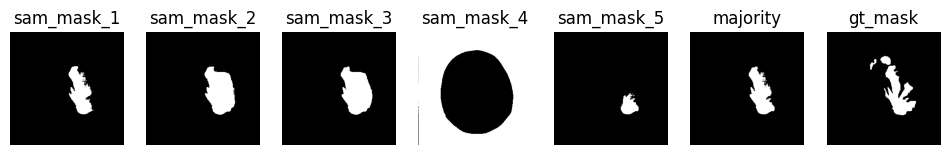

In [29]:
sv.plot_images_grid(
    images=[sam_mask_1[0], sam_mask_2[0], sam_mask_3[0], sam_mask_4[0], sam_mask_5[0], majority_vote[0], gt_mask[:, :, 0]],
    grid_size=(1, 7),
    titles=['sam_mask_1', 'sam_mask_2', "sam_mask_3", "sam_mask_4", "sam_mask_5", "majority","gt_mask"]
)

In [30]:
(majority_vote == majority.numpy()).sum() == 256*256

True

# Majority Voting: Weighted Voting

In [31]:
## 0.5 : 0.74
# weighted_mask = 0.25 * sam_mask_1 + 0.25 * sam_mask_2 + 0.25 * sam_mask_3 + 0.25 * sam_mask_4
# weighted_mask = np.array((weighted_mask.squeeze()> 0.5), dtype=np.float32)

## 0.5 : 0.83
# weighted_mask = 0.33 * sam_mask_1 + 0.28 * sam_mask_2 + 0.22 * sam_mask_3 + 0.17 * sam_mask_4
# weighted_mask = np.array((weighted_mask.squeeze()> 0.5), dtype=np.float32)


# weighted_mask = 0.1 * sam_mask_1 + 0.1 * sam_mask_2 + 0.1 * sam_mask_3 + 0.7 * sam_mask_4
# weighted_mask = np.array((weighted_mask.squeeze()> 0.3), dtype=np.float32)

# weighted_mask = 0.1 * sam_mask_1 + 0.4 * sam_mask_2 + 0.4 * sam_mask_3 + 0.1 * sam_mask_4
# weighted_mask = np.array((weighted_mask.squeeze()> 0.7), dtype=np.float32)


# sv.plot_images_grid(
#     images=[sam_mask_1[0], sam_mask_2[0], sam_mask_3[0], sam_mask_4[0], weighted_mask, gt_mask[:, :, 0]],
#     grid_size=(1, 6),
#     titles=['sam_mask_1', 'sam_mask_2', "sam_mask_3", "sam_mask_4", "weighted_mask","gt_mask"]
# )